<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

In [1]:
import matplotlib
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import itertools
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

In [2]:
same_edges = 0
same_edges_reversed = 0
self_edges = 0
u_greater_v = 0
initial_graph = nx.Graph()
with open('graph_in.txt') as openfileobject:
    for line in openfileobject:
        args = line.split(' ')
        u = int(args[0])-1
        v = int(args[1])-1
        same_edges += initial_graph.has_edge(u,v)
        same_edges_reversed += initial_graph.has_edge(v,u)
        self_edges += u == v
        u_greater_v += u>v
        initial_graph.add_edge(u,v)

In [3]:
print(initial_graph)
print(same_edges)
print(same_edges_reversed)
print(self_edges)
print(u_greater_v)

Graph with 430 nodes and 565 edges
0
0
1
0


 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [4]:
initial_node_count = initial_graph.number_of_nodes()
initial_edge_count = initial_graph.number_of_edges()
initial_degree_avg = sum(nx.degree_centrality(initial_graph).values()) / initial_node_count
initial_connected_components = len(sorted(nx.connected_components(initial_graph), key=len, reverse=True))

print("initial number of nodes:",initial_node_count)
print("initial number of edges:",initial_edge_count)
print("initial average degree of nodes:",initial_degree_avg)
print("initial number of connected components:",initial_connected_components)

initial number of nodes: 430
initial number of edges: 565
initial average degree of nodes: 0.0061256572884480125
initial number of connected components: 95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [5]:
unconnected_pairs = []

for i in range (initial_node_count):
    for j in range (i+1,initial_node_count):
        if((i, j) not in initial_graph.edges()):
            unconnected_pairs.append((i, j))

print(len(unconnected_pairs))


91671


*Παρατήρηση<br><br>
Η υλοποίηση έγινε αρχικά χρησιμοποιώντας τον πίνακα γειτνίασης και συγκεκριμένα το μέρος που βρίσκεται πάνω από την κύρια διαγώνιο όμως εντοπίστηκαν σφάλματα στις τιμές που περιείχε γι' αυτό έγινε νέα υλοποίηση με τον πιο πάνω τρόπο*

<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [6]:
removable_edges = []
temp_graph = initial_graph.copy()
for e in initial_graph.edges:
    temp_graph.remove_edge(*e)
    if (len(sorted(nx.connected_components(temp_graph), key=len, reverse=True)) == initial_connected_components) and ( temp_graph.number_of_nodes() == initial_node_count) and (e[0]!=e[1]):
        (u,v) = e
        removable_edges.append((min(u,v),max(u,v))) 
    else:
        temp_graph.add_edge(*e)
print(len(removable_edges))

229


Παρατηρήσεις<br>
* Η τοποθέτηση των ακμών στο σύνολο removable_edges ξεκίνησε από την πρώτη ακμή προς την τελευταία
* Η μία self edge του γράφου δεν προστέθηκε στο σύνολο removable_edges για να μην προκύψουν ασάφειες στα επόμενα ερωτήματα

<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [7]:
df_edges = unconnected_pairs + removable_edges
df_links = list(np.zeros(len(unconnected_pairs)))+list(np.ones(len(removable_edges)))
df_edges, df_links = zip(*sorted(zip(df_edges, df_links)))
u, v = zip(*df_edges)
df = pd.DataFrame({'u': u, 'v': v, 'link': df_links})
print(len(df))
print(df)



# #build graph G'=G_reduced
G_reduced = initial_graph.copy()
G_reduced.remove_edges_from(removable_edges)

91900
         u    v  link
0        0    1   1.0
1        0    2   1.0
2        0    3   1.0
3        0    5   0.0
4        0    6   0.0
...    ...  ...   ...
91895  425  429   0.0
91896  426  427   0.0
91897  426  428   0.0
91898  426  429   0.0
91899  428  429   0.0

[91900 rows x 3 columns]


In [8]:
reduced_node_count = G_reduced.number_of_nodes()
reduced_edge_count = G_reduced.number_of_edges()
reduced_degree_avg = sum(nx.degree_centrality(G_reduced).values()) / reduced_node_count
reduced_connected_components = len(sorted(nx.connected_components(G_reduced), key=len, reverse=True))

print("reduced graph's number of nodes:",reduced_node_count)
print("reduced graph's number of edges:",reduced_edge_count)
print("reduced graph's average degree of nodes:",reduced_degree_avg)
print("reduced graph's number of connected components:",reduced_connected_components)

reduced graph's number of nodes: 430
reduced graph's number of edges: 336
reduced graph's average degree of nodes: 0.0036428687591478492
reduced graph's number of connected components: 95


<html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
     <li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

In [9]:
jaccard_preds = list(nx.algorithms.link_prediction.jaccard_coefficient(G_reduced))
print(len(jaccard_preds))
max_p = 0
max_edge = (0,0)
for u, v, p in jaccard_preds:
    if p > max_p:
        max_p = p
        max_edge = (u,v)
print(max_edge, max_p)


91900
(3, 45) 1.0


Παρατήρηση<br><br>
Ο Α.Μ. είναι 03117601 επομένως πιο πάνω εμφανίζεται μόνο η ακμή με την υψηλότερη τιμή μετρικής

In [10]:
j_u = []
j_v = []
jaccard_ps = []
for u, v, p in jaccard_preds:
    j_u.append(u)
    j_v.append(v)
    jaccard_ps.append(p)

j_u, j_v, jaccard_ps = zip(*sorted(zip(j_u, j_v, jaccard_ps)))
jaccard_ps = np.array(jaccard_ps)

(0.7074235807860262, 0.3207920792079208, 0.9955386289445048)
(0.6899563318777293, 0.324435318275154, 0.9956474428726877)
(0.6768558951965066, 0.34598214285714285, 0.996006528835691)
(0.6026200873362445, 0.4169184290030212, 0.9969096844396083)
(0.5502183406113537, 0.5101214574898786, 0.9975625680087051)


Text(0.5, 1.0, 'Accuracy')

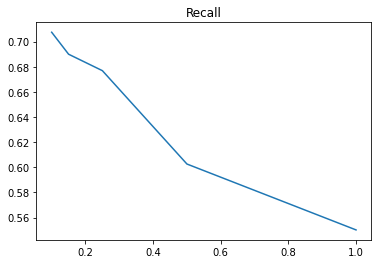

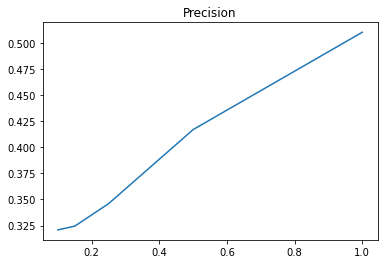

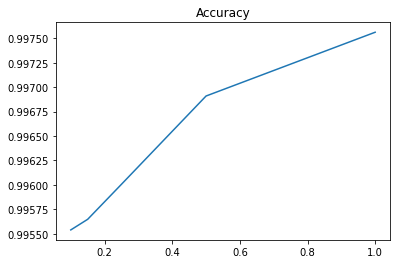

In [11]:
def JCfunction(threshold_jc):   #uncomment and complete
    link_pred = np.where(jaccard_ps >= threshold_jc, 1, 0)
    recall_jc = recall_score(df_links, link_pred)
    precision_jc = precision_score(df_links, link_pred)
    accuracy_jc = accuracy_score(df_links, link_pred)
    return recall_jc, precision_jc, accuracy_jc; #uncomment and complete

k = 1   # 03117601
recs = []
pres = []
accs = []
thresholds = [0.1, 0.15, 0.25, 0.5, 1.0]
for threshold in thresholds:
    print(JCfunction(threshold))
    rec, pre, acc = JCfunction(threshold)
    recs.append(rec)
    pres.append(pre)
    accs.append(acc)
plt.figure(1)
plt.plot(thresholds,recs)
plt.title('Recall')
plt.figure(2)
plt.plot(thresholds,pres)
plt.title('Precision')
plt.figure(3)
plt.plot(thresholds,accs)
plt.title('Accuracy')


<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

In [12]:
#replicate of the dataframe "unconnected+removables"---dataframe will be used again in (4)
df_copy = df.copy()

In [13]:
#dataframe for similarity-based measurement values
#Jaccard Coefficient
df_copy = df_copy.assign(JaccCoeff=jaccard_ps)

#Preferential Attachment
pa_preds = list(nx.algorithms.link_prediction.preferential_attachment(G_reduced))
pa_edges = []
pa_ps = []
for u, v, p in pa_preds:
    pa_edges.append((u, v))
    pa_ps.append(p)
pa_edges, pa_ps = zip(*sorted(zip(pa_edges, pa_ps)))
df_copy = df_copy.assign(PrAttachment=pa_ps)

#Resource Allocation
ra_preds = list(nx.algorithms.link_prediction.resource_allocation_index(G_reduced))
ra_edges = []
ra_ps = []
for u, v, p in ra_preds:
    ra_edges.append((u, v))
    ra_ps.append(p)
ra_edges, ra_ps = zip(*sorted(zip(ra_edges, ra_ps)))
df_copy = df_copy.assign(ResAllocation=ra_ps)


print(df_copy)

         u    v  link  JaccCoeff  PrAttachment  ResAllocation
0        0    1   1.0        0.0             1            0.0
1        0    2   1.0        0.0             2            0.0
2        0    3   1.0        0.0             1            0.0
3        0    5   0.0        0.0             7            0.0
4        0    6   0.0        0.0             1            0.0
...    ...  ...   ...        ...           ...            ...
91895  425  429   0.0        0.0             1            0.0
91896  426  427   0.0        0.0             2            0.0
91897  426  428   0.0        0.0             1            0.0
91898  426  429   0.0        0.0             1            0.0
91899  428  429   0.0        1.0             1            0.5

[91900 rows x 6 columns]


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [14]:
# uncomment whole cell
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# X =             #features, uncomment and complete
# y = ...['link']  # target, uncomment and complete
x = df_copy.loc[:, df_copy.columns != 'link']
y = df_copy['link']  # target, uncomment and complete
# print(x)
# print(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 0) #uncomment and complete

In [15]:
# uncomment whole cell
classifier = RandomForestClassifier()   

from sklearn.preprocessing import MinMaxScaler 
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

In [16]:
model.fit(X_train_scaled, y_train)#train the model, uncomment and complete

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [17]:
predictions = model.predict(X_test_scaled)       #uncomment
print(predictions[0]) #get (1 - A.M. last digit) first predictions, uncomment and complete

0.0


In [18]:
print(X_test.loc[(X_test['u'] == 1-1) & (X_test['v'] == 47-1)])
print(X_train.loc[(X_train['u'] == 1-1) & (X_train['v'] == 47-1)])


Empty DataFrame
Columns: [u, v, JaccCoeff, PrAttachment, ResAllocation]
Index: []
    u   v  JaccCoeff  PrAttachment  ResAllocation
44  0  46        0.0             1            0.0


In [19]:
predict_proba = model.predict_proba(X_train_scaled)  # uncomment and complete
print(predict_proba[44])
print(print(df_copy.loc[(df_copy['u'] == 1-1) & (df_copy['v'] == 47-1)]))


[9.99996149e-01 3.85133834e-06]
    u   v  link  JaccCoeff  PrAttachment  ResAllocation
44  0  46   0.0        0.0             1            0.0
None


Παρατηρήσεις
* Η ακμή 1-47 είναι στο πιο πάνω df η ακμή 0-46 λόγω της αφαίρεσης μίας μονάδας από κάθε κόμβο στο πρώτο βήμα της άσκησης ώστε να ξεκινά η αρίθμηση από τον κόμβο 0
* Αυτή η ακμή εντοπίστηκε στο test set με index = 44 για τον διαχωρισμό με random_state = 0
* Η συνάρτηση predict_proba δίνει μεγάλη πιθανότητα να ανήκει η ακμή στην πρώτη κατηγορία, δλδ να μην υπάρχει. Όπως φαίνεται πιο πάνω η τιμή link για την ακμή είναι 0 επομένως στην πραγματικότητα όντως δεν υπάρχει η ακμή

<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [20]:
#install node2vec with conda / pip
from node2vec import Node2Vec   #uncomment
import multiprocessing          #uncomment

#generate walks
# uncomment and complete
node2vec_walker = Node2Vec(G_reduced, p=1.0, q=1.0, dimensions=128, num_walks=10, walk_length=80, workers=multiprocessing.cpu_count())

#train node2vec model
n2v_model = node2vec_walker.fit(window=10, min_count=1) #uncomment and complete

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [24]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
#uncomment:
x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df['u'], df['v'])]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 0)  #uncomment and complete

In [26]:
#uncomment whole cell
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train,y_train)   #uncomment and complete

y_pred=classifier.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9987377584330794


<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>